# 1. Datensatz

## 1.1 Infos zum Datensatz

Ein erheblicher Teil des Gesamtenergieverbrauchs weltweit entfällt heutzutage auf Gebäude, insbesondere auf Heizung, Lüftung und Klimatechnik. Hier bieten sich durch intelligente Steuerung große Einsparpotenziale. Ein Baustein dafür sind Sensoren, die erkennen, ob sich Menschen in bestimmten Teilen des Gebäudes aufhalten und diese Information an die Gebäudesteuerung weiterleiten, sodass Energieverbraucher dynamisch zu- und abgeschaltet werden können. Der vorliegende Datensatz (`Datensatz-Sensor.csv`) enthält Messdaten, die von einem Sensor in einem Bürogebäude aufgezeichnet wurden. Eine Zeile beschreibt die Erfassung verschiedener Messwerte zu einem bestimmten Zeitpunkt an einem festen Ort (d.h., der Sensor wurde nicht bewegt). Leider kann der Sensor aktuell noch nicht messen, ob sich Personen im Raum befinden. Für den vorliegenden Zeitraum wurde die Anwesenheit einer Person aber manuell kontrolliert und den Messdaten hinzugefügt. Insgesamt existieren folgende Felder in den Daten:
- Datum: Zeitstempel im Format JJJJ-MM-DD hh:mm:ss
- Temperatur: Temperatur in Grad Celsius (°C)
- Luftfeuchtigkeit: relative Luftfeuchtigkeit in %
- CO2: CO2 Gehalt in ppm
- Wassergehalt: Verhältnis von Gewicht des verdunsteten Wassers zum Gewicht der trockenen Luft in kg Wasserdampf / kg Luft (abgeleitet aus Temperatur und Luftfeuchtigkeit)
- Anwesenheit: Ist eine Person anwesend (1) oder nicht (0).

# 2. Explorative Datenanalyse (EDA)

## 2.1 Überblick

Bevor wir mit der Bereinigung oder Modellierung beginnen, verschaffen wir uns einen Überblick über die Struktur der Rohdaten.  
Ziel dieses ersten Überblicks ist es:
1.  Die **Dimensionen** des Datensatzes zu prüfen (Wie viele Zeilen / Spalten?).
2.  Die **Datentypen** zu validieren (Wird das Datum korrekt erkannt?).
3.  Erste **Auffälligkeiten** zu identifizieren (Gibt es fehlende Werte oder offensichtliche Ausreißer in der Statistik?).

Dafür brauchen wir folgende Imports:

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import holidays
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# SKlearn Model imports

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import plot_tree

In diesem Schritt laden wir den Datensatz `Datensatz-Sensor.csv` und prüfen die Datenqualität.  
Wir untersuchen die Struktur mit `df.info()` und schauen uns statistische Kennzahlen mit `df.describe()` an, um erste Auffälligkeiten (z.B. fehlende Werte oder Ausreißer) zu identifizieren.

In [3]:
df = pd.read_csv("data/Datensatz-Sensor.csv")

# Die ersten 5 Zeilen anzeigen (Wie sehen die Daten aus?)
display(df.head())

# Infos zu Datentypen und fehlenden Werten
print("Info zu Datentypen:")
print(df.info())

# Statistische Übersicht
print("\nStatistische Beschreibung:")
display(df.describe())

Datum  Temperatur  Feuchtigkeit         CO2  Wassergehalt  \
0  2015-02-02 14:19:00     23.7000        26.272  749.200000      0.004764   
1  2015-02-02 14:19:59     23.7180        26.290  760.400000      0.004773   
2  2015-02-02 14:21:00     23.7300        26.230  769.666667      0.004765   
3  2015-02-02 14:22:00     23.7225        26.125  774.750000      0.004744   
4  2015-02-02 14:23:00     23.7540        26.200  779.000000      0.004767   

   Anwesenheit  
0            1  
1            1  
2            1  
3            1  
4            1

Info zu Datentypen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datum         19236 non-null  object 
 1   Temperatur    19134 non-null  float64
 2   Feuchtigkeit  18915 non-null  float64
 3   CO2           19236 non-null  float64
 4   Wassergehalt  18777 non-null  float64
 5   Anwesenheit   19236 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 901.8+ KB
None

Statistische Beschreibung:


Temperatur  Feuchtigkeit           CO2  Wassergehalt   Anwesenheit
count  19134.000000  18915.000000  19236.000000  18777.000000  19236.000000
mean      21.322743     27.451396    634.818354      0.004189      0.226606
std        3.908221      5.008853    260.246196      0.000759      0.418647
min       19.000000     16.745000      0.000000      0.002674      0.000000
25%       20.133333     24.290000    454.500000      0.003699      0.000000
50%       20.675000     27.171429    545.500000      0.004278      0.000000
75%       21.600000     31.050000    734.541667      0.004799      0.000000
max       55.998944     39.500000   2028.500000      0.006476      1.000000

## 2.2 Auffälligkeiten in den Daten:
Bei der Betrachtung der Statistik (`describe`) und Datentypen (`info`) fallen folgende Probleme auf, die im nächsten Schritt bereinigt werden müssen:

1.  **Falsches Datumsformat:** Die Spalte `Datum` wird aktuell als Text (`object`) erkannt und nicht als Zeitstempel. Zudem sind die Sekunden oft auf `:59`, was auf einen leichten Zeitversatz hindeutet.
2.  **Unrealistische Temperaturen:** Der Maximalwert liegt bei über 50°C. Da es sich um ein Büro handelt, ist dies ein offensichtlicher Messfehler (Ausreißer).
3.  **CO2-Ausfälle:** Der Minimalwert bei CO2 ist 0.0 ppm. Da die natürliche Außenluft bereits ca. 400 ppm CO2 enthält, deutet dies auf Sensorausfälle hin.

## 2.3 Visualisierung der Rohdaten
Um die Verteilung und mögliche Fehler besser zu erkennen, plotten wir die Zeitreihen für Temperatur und CO2.
Hierbei erwarten wir, die oben identifizierten Ausreißer (Temperatur > 50°C und CO2 = 0) grafisch bestätigen zu können.

In [15]:
# # Damit Plotly die Zeitachse richtig malt, wandeln wir das Datum kurz um
df["Datum"] = pd.to_datetime(df["Datum"])

# Plot: Temperatur
fig_temp = px.scatter(df, x="Datum", y="Temperatur", title="Temperaturverlauf", color_continuous_scale="Blues")
fig_temp.update_xaxes(tickmode = "linear")
fig_temp.show()

# Plot: CO2
fig_co2 = px.scatter(df, x="Datum", y="CO2", title="CO2-Verlauf", color_continuous_scale="Blues")
fig_co2.update_xaxes(tickmode = "linear")
fig_co2.show()

# Boxplot co2 / Temperatur
fig_box_co2 = px.box(df, y="CO2", title="Statistische Verteilung & Ausreißer (CO2)")
fig_box_co2.show()

fig_box_temp = px.box(df, y="Temperatur", title="Statistische Verteilung & Ausreißer (Temperatur)")
fig_box_temp.show()

# Plot: Anwesenheit am Wochentag
df["Anwesenheit_Prozent"] = df.groupby(df["Datum"].dt.date)["Anwesenheit"].transform(lambda x: x.sum() / x.count() * 100)

grouped_percentages = df.groupby(df["Datum"].dt.dayofweek).agg(Anwesenheit_Prozent=("Anwesenheit_Prozent", "first")).reset_index()

# Bar: Anwesenheit in %
fig_anwesenheit = px.bar(
    grouped_percentages,
    x="Datum",
    y="Anwesenheit_Prozent",
    title="Durchschnittliche Anwesenheit pro Tag",
    color_continuous_scale="Blues"
)
fig_anwesenheit.update_xaxes(tickmode="linear").show()
df.drop(columns=["Anwesenheit_Prozent"], inplace=True)

In [ ]:
def create_presence_polar_chart(df):
    df_copy = df.copy()

    df_copy["hour"] = df_copy["Datum"].dt.hour

    # Durchschnittliche Anwesenheit pro Stunde (0-1)
    hourly_presence = (
        df_copy.groupby("hour")["Anwesenheit"]
        .mean()
        .reset_index()
        .rename(columns={"Anwesenheit": "presence_mean"})
    )

    # Alle 24 Stunden sicherstellen
    all_hours = pd.DataFrame({"hour": range(24)})
    hourly_presence = all_hours.merge(hourly_presence, on="hour", how="left").fillna(0.0)

    # Winkel für Polar-Plot (15 Grad pro Stunde)
    hourly_presence["theta"] = hourly_presence["hour"] * 15
    hourly_presence["presence_pct"] = hourly_presence["presence_mean"] * 100

    # Ersten Punkt am Ende hinzufügen für geschlossene Linie
    first_row = hourly_presence.iloc[0].copy()
    first_row["theta"] = 360  # 360 Grad = 0 Grad
    hourly_presence = pd.concat([hourly_presence, first_row.to_frame().T], ignore_index=True)

    # Farben (Blues)
    line_color = px.colors.sequential.Blues[-1] # dunkelblau für Linie
    fill_color = "rgba(0, 82, 164, 0.25)" # halbtransparentes Blau

    # Polar-Liniendiagramm
    fig = px.line_polar(
        hourly_presence,
        r="presence_pct",
        theta="theta",
        title="Durchschnittliche Anwesenheit über 24 Stunden",
        template="plotly_white"
    )

    fig.update_layout(
        template="plotly_white",
        paper_bgcolor="white",
        plot_bgcolor="white",
        polar=dict(
            bgcolor="rgba(225, 235, 245, 0.6)", # helles graublau
            radialaxis=dict(
                title="Anwesenheit (%)",
                tickangle=0,
                showgrid=True,
                gridcolor="white",
                linecolor="white",
                tickfont=dict(color="#1f4e79"),
            ),
            angularaxis=dict(
                tickmode="array",
                tickvals=[i * 15 for i in range(24)],
                ticktext=[f"{i:02d}:00" for i in range(24)],
                direction="clockwise",
                rotation=90,
                showgrid=True,
                gridcolor="white",
                linecolor="white",
                tickfont=dict(color="#1f4e79"),
            )
        ),
        width=700,
        height=700,
        showlegend=False
    )

    fig.update_traces(
        line=dict(color=line_color, width=3),
        fill="tonext",
        fillcolor=fill_color
    )

    return fig

polar_fig = create_presence_polar_chart(df)
polar_fig.show()

## 2.4 Analyse fehlender Werte
Datenlücken können durch Sensorausfälle oder Übertragungsfehler entstehen. Da wir nicht mit fehlenden Werte (`NaN`) arbeiten wollen, prüfen wir hier, welche Spalten betroffen sind.
Dies liefert uns die Begründung für die spätere **Interpolation** der Werte.

In [4]:
# Berechnen der fehlenden Werte pro Spalte
missing_count = df.isnull().sum()

# Wir filtern und zeigen nur Spalten an, die wirklich fehlende Werte haben
missing_data = missing_count[missing_count > 0]

print("Anzahl fehlender Werte pro Spalte:")
print(missing_data)

Anzahl fehlender Werte pro Spalte:
Temperatur      102
Feuchtigkeit    321
Wassergehalt    459
dtype: int64


## 2.5 Korrelationsanalyse
In diesem Schritt untersuchen wir die statistischen Zusammenhänge zwischen den verschiedenen Messwerten.

In [5]:
# Korrelationsmatrix berechnen
numeric_df = df.select_dtypes(include=["number"])
corr_matrix = numeric_df.corr()

# Heatmap anzeigen
fig_corr = px.imshow(corr_matrix, text_auto=".2f", aspect="auto", color_continuous_scale="blues", title="Korrelationsmatrix")
fig_corr.show()

# Anwesenheit vs. CO2
# Da Anwesenheit (0/1) kategorisch ist, eignet sich ein Boxplot besser als ein Scatterplot
df["Status"] = df["Anwesenheit"].map({0: "Leer", 1: "Besetzt"})

fig_box = px.box(df, x="Status", y="CO2", color="Status",title="Einfluss von Anwesenheit auf den CO2-Gehalt", color_discrete_map={"Leer": "red", "Besetzt": "blue"})
fig_box.show()

# Aufräumen
df = df.drop(columns=["Status"])

# 3. Datenvorverarbeitung und Feature Engineering

## 3.1 Datenvorverarbeitung und Aufteilung in Trainings- und Testdaten

In diesem Abschnitt werden die Rohdaten für die Modellierung vorbereitet. Wir definieren Funktionen für die Bereinigung, um eine gute Verarbeitung (auch für spätere neue Daten) sicherzustellen.

1.  **Technische Vorbereitung (`datumkorriegieren`):**
    * Die Spalte `Datum` wird in ein Datetime-Format umgewandelt.
    * Zeitstempel werden auf volle Minuten gerundet, um Unschärfen bei der Messung auszugleichen.
    * Anschließend wird der Datensatz sortiert.

2.  **Train-Test-Split (Zeitreihe):**
    * Da es sich um zeitabhängige Daten handelt, wird **nicht zufällig gemischt** (`shuffle=False`).
    * Wir trennen die Daten chronologisch: Die ersten 80% dienen dem Training, die letzten 20% als Testdaten.

3.  **Inhaltliche Bereinigung (`bereinige_daten`):**
    * **Ausreißer-Behandlung:** Unphysikalische Werte (z. B. Temperatur > 40°C) werden entfernt.
    * **Imputation:** Fehlende Werte werden mittels linearer Interpolation aufgefüllt.
    * **Wichtig:** Dieser Schritt erfolgt erst **nach dem Split** getrennt für Training und Test. Dadurch verhindern wir *Data Leakage*, das Modell darf beim Auffüllen von Lücken im Training keine Informationen aus der Zukunft (Testdaten) nutzen.

### Zeit-Korrektur

In [6]:
# Datum korrigieren
def datumkorriegieren(df_input):
    df = df_input.copy()
    if df["Datum"].dtype == "object":
        df["Datum"] = pd.to_datetime(df["Datum"])

    # Runden: Wenn Sekunde == 59, addiere 1 Sekunde
    mask_59 = df["Datum"].dt.second == 59
    if mask_59.sum() > 0:
        df.loc[mask_59, "Datum"] += pd.Timedelta(seconds=1)

    return df


### Ausreißer entfernen und Interpolation

In [7]:
def bereinige_daten(df_input):
    df = df_input.copy()

    # Ausreißer weg
    df.loc[df["Temperatur"] > 40, "Temperatur"] = np.nan
    df.loc[df["CO2"] < 50, "CO2"] = np.nan

    # Lücken füllen
    df = df.interpolate(method="linear", limit_direction="both")
    
    return df

### Anwendung der Funktionen

In [8]:
# Datum - Wir arbeiten absofort auf einer Kopie weiter
df_clean = datumkorriegieren(df.copy()) 
df_clean = df_clean.sort_values("Datum") # Wichtig für Zeitreihe

# Splitten (Training & Test)
X = df_clean.drop(columns=["Anwesenheit"])
y = df_clean["Anwesenheit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Daten getrennt bereinigen
X_train_clean = bereinige_daten(X_train)
X_test_clean = bereinige_daten(X_test)

### Visualisierung der neuen Daten

In [9]:
# Plot: Temperatur
fig_temp = px.scatter(X_train_clean, x="Datum", y="Temperatur", title="Temperaturverlauf", color_continuous_scale="Blues")
fig_temp.update_xaxes(tickmode = "linear")
fig_temp.show()

# Plot: CO2
fig_co2 = px.scatter(X_train_clean, x="Datum", y="CO2", title="CO2-Verlauf", color_continuous_scale="Blues")
fig_co2.update_xaxes(tickmode = "linear")
fig_co2.show()

# Boxplot: Co2 - zeigt Ausreißer noch extremer
fig_box_co2 = px.box(X_train_clean, y="CO2", title="Statistische Verteilung & Ausreißer (CO2)")
fig_box_co2.show()

# Boxplot: Temperatur
fig_box_temp = px.box(X_train_clean, y="Temperatur", title="Statistische Verteilung & Ausreißer (Temperatur)")
fig_box_temp.show()

## 3.2 Feature Engineering  
Im Feature Engineering erzeugen wir neue Variablen ("Features"), die dem Modell helfen sollen Muster schneller zu finden.

Wir implementieren folgende Sachen:

1.  **Zyklische Zeitkodierung (Sinus/Cosinus):**
    * Ein Modell versteht nicht automatisch, dass "23:59 Uhr" und "00:01 Uhr" zeitlich nah beieinander liegen.
    * Durch die Transformation der Uhrzeit in Sinus- und Cosinus-Werte bilden wir den 24-Stunden-Kreislauf mathematisch ab.

2.  **Physikalische Trends (CO2-Delta):**
    * Nicht nur der absolute CO2-Wert ist wichtig, sondern auch wie schnell er steigt. Ein schneller Anstieg (`CO2_Delta_15min`) ist ein Indikator dafür, dass Personen den Raum betreten haben.

3.  **Kalender-Logik & Feiertage:**
    * Mithilfe der Bibliothek `holidays` unterscheiden wir automatisch zwischen Werktagen und freien Tagen (Feiertage).

4.  **Expertenwissen:**
    * Anstatt das Modell statistisch "raten" zu lassen, wann gearbeitet wird, definieren wir basierend auf Domain-Wissen eine **Kernarbeitszeit** (Mo-Fr, 06:00 - 19:00 Uhr). Dies macht das Modell robust und verhindert Data Leakage.

Zum Schluss entfernen wir die ursprünglichen Spalten `Datum` und `Jahr`, da diese Informationen nun in den neuen Features besser repräsentiert sind.

In [10]:
# Das ist die Haupt-Funktion für Features
def erstelle_features(df_input):
    df = df_input.copy()
    
    # Basis-Zeit-Features
    stunde = df["Datum"].dt.hour
    minute = df["Datum"].dt.minute
    wochentag = df["Datum"].dt.dayofweek
    df["Jahr"] = df["Datum"].dt.year
    df["Wochentag"] = wochentag

    # Zyklische Zeit 
    minute_of_day = stunde * 60 + minute
    df["time_sin"] = np.sin(2 * np.pi * minute_of_day / 1440)
    df["time_cos"] = np.cos(2 * np.pi * minute_of_day / 1440)

    # CO2 Delta
    # Die ersten 15 Zeilen sind NaN, wir füllen mit 0
    df["CO2_Delta_15min"] = df["CO2"].diff(periods=15).fillna(0)

    # Feiertage (Holidays)
    # Wir holen uns die Jahre aus dem Datensatz
    years = df["Jahr"].unique()
    de_holidays = holidays.DE(years=years) 
    
    def ist_werktag(datum):
        if datum in de_holidays: return 0 # Feiertag -> Kein Werktag
        if datum.dayofweek >= 5: return 0 # Wochenende -> Kein Werktag
        return 1
    
    df["Tagesart_Werktag"] = df["Datum"].apply(ist_werktag)

    # Bürozeit / Kernzeit
    def check_kernzeit_fix(row):
        wd = row["Wochentag"]
        hr = row["Datum"].hour
        
        # 1: Wochenende ist keine Kernarbeitszeit
        if wd >= 5: 
            return 0
            
        # 2: Feste Uhrzeiten
        if 6 <= hr <= 19:
            return 1
        else:
            return 0
    
    df["Ist_Buerozeit"] = df.apply(check_kernzeit_fix, axis=1)

    return df


In [11]:
# Ablauf nach dem Split
X_train_final = erstelle_features(X_train_clean)
X_test_final = erstelle_features(X_test_clean)

# Aufräumen: Spalten, die das Modell nicht braucht, droppen
# "Datum" und "Jahr" brauchen wir nicht mehr
cols_to_drop = ["Datum", "Jahr"] 
X_train_final = X_train_final.drop(columns=cols_to_drop)
X_test_final = X_test_final.drop(columns=cols_to_drop)

print("\nFertige Spalten für das Modell:")
print(X_train_final.columns.tolist())


Fertige Spalten für das Modell:
['Temperatur', 'Feuchtigkeit', 'CO2', 'Wassergehalt', 'Wochentag', 'time_sin', 'time_cos', 'CO2_Delta_15min', 'Tagesart_Werktag', 'Ist_Buerozeit']


In [12]:
df_plot = X_train_final.copy()
df_plot["Datum"] = X_train["Datum"]

# Plot-Code (angepasst auf Training + Fehler entfernt)
fig_werktag = px.histogram(df_plot, x="Datum", color="Tagesart_Werktag").update_xaxes(tickangle=-45, tickmode="linear")
fig_werktag.show()

# 4. Modelle Modellierung und Evaluation

## 4..1 Modellierung: Vorbereitung

Bevor wir die Algorithmen trainieren, sind zwei technische Schritte notwendig, um die Qualität und Vergleichbarkeit der Modelle zu gewährleisten:

1.  **Feature Skalierung (StandardScaler):**
    * Einige Algorithmen (wie die **Logistische Regression**) arbeiten mit Abständen oder Gradientenverfahren und benötigen daher skalierte Daten.
    * Entscheidungsbäume benötigen dies zwar theoretisch nicht, aber wir skalieren einheitlich alle Daten, um die Modelle besser vergleichbar zu machen.
    * **Wichtig:** Der Scaler wird nur auf den **Trainingsdaten** "gelernt" (`fit_transform`) und dann auf die Testdaten angewendet (`transform`). So verhindern wir, dass Informationen über die Verteilung der Testdaten ins Training einfließen.
    * Wir wandeln die skalierte Matrix zurück in einen `DataFrame`, um die Spaltennamen für Analysen (Feature Importance) zu behalten.

2.  **Validierung (TimeSeriesSplit):**
    * Für die Hyperparameter-Optimierung (GridSearch) dürfen wir kein normales "Shuffle-Cross-Validation" nutzen, da dies die Zeitstruktur zerstören würde.
    * Stattdessen nutzen wir `TimeSeriesSplit`. Dabei wird das Modell auf einem vergangenen Zeitraum trainiert und auf einem darauffolgenden Zeitraum validiert.

In [13]:
# Split überspringen!
# Wir nutzen direkt: X_train_final, y_train, X_test_final, y_test

# Skalierung 
scaler = StandardScaler()

# Damit wir die Spaltennamen behalten (wichtig für späteres Auswerten)
# Scaler macht die Spaltennamen weg
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final), 
    columns=X_train_final.columns,
    index=X_train_final.index)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final), 
    columns=X_test_final.columns,
    index=X_test_final.index)

# Cross-Validation Strategie für Zeitreihen festlegen
tscv = TimeSeriesSplit(n_splits=5)

results_list = []
print("fertig")
print(f"Trainingsdaten Form: {X_train_scaled.shape}")

fertig
Trainingsdaten Form: (15388, 10)


## 4.2 Modell 1: Logistische Regression
Wir starten mit der Logistischen Regression als Basis. Sie trennt die Klassen linear.

In [14]:
# Modell initialisieren & trainieren
model_lr = LogisticRegressionCV(cv=tscv, scoring="roc_auc", class_weight="balanced", random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Vorhersage
y_pred_lr = model_lr.predict(X_test_scaled)

# Auswertung speichern
report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)

results_list.append({
    "Modell": "Logistische Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision (1)": report_lr.get("1", {}).get("precision", 0.0),
    "Recall (1)": report_lr.get("1", {}).get("recall", 0.0),
    "F1-Score (1)": report_lr.get("1", {}).get("f1-score", 0.0)
})

print("Logistische Regression fertig.")

Logistische Regression fertig.


## 4.4 Modell 2: Random Forest
Der Random Forest kombiniert viele Entscheidungsbäume ("Ensemble"). Er ist meist robuster und genauer als einzelne Bäume.

In [15]:
# Modell initialisieren
model_rf = RandomForestClassifier(random_state=42)

# Trainieren
model_rf.fit(X_train_scaled, y_train)

# Vorhersage
y_pred_rf = model_rf.predict(X_test_scaled)

# Auswertung speichern
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
results_list.append({
    "Modell": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision (1)": report_rf["1"]["precision"],
    "Recall (1)": report_rf["1"]["recall"],
    "F1-Score (1)": report_rf["1"]["f1-score"]
})

print("Random Forest fertig.")

Random Forest fertig.


## 4.5 Modell 3: Gradient Boosting

Für das Boosting-Verfahren setzen wir auf `HistGradientBoostingClassifier` (Histogram-based Gradient Boosting) anstelle des klassischen `GradientBoostingClassifier`.

- Das klassische Gradient Boosting muss für jeden Split-Punkt alle Datenwerte sortieren und prüfen. Das wird bei vielen Daten sehr langsam.
- Der **Histogram-basiertes Ansatz** fasst die stetigen Messwerte (z. B. Temperatur 20.1°C, 20.2°C) in "Eimer" (Bins) zusammen (z. B. 256 Bins). Der Algorithmus muss dann nur noch wenige Trennpunkte prüfen.
- **Ergebnis:** Das Training ist um ein Vielfaches schneller (oft Faktor 10 bis 100), was besonders bei der Hyperparameter-Optimierung (GridSearch) wertvolle Zeit spart.


In [16]:
# Modell initialisieren
gb_model = HistGradientBoostingClassifier(random_state=42)

gb_model.fit(X_train_scaled, y_train)

# Vorhersage
y_pred_gb = gb_model.predict(X_test_scaled)

# Auswertung speichern
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)
results_list.append({
    "Modell": "Hist Gradient Boosting",
    "Accuracy": accuracy_score(y_test, y_pred_gb),
    "Precision (1)": report_gb["1"]["precision"],
    "Recall (1)": report_gb["1"]["recall"],
    "F1-Score (1)": report_gb["1"]["f1-score"]
})

print("HistGradientBoosting fertig.")

HistGradientBoosting fertig.


## 4.5 Modell 4 (Optional): Entscheidungsbaum (Decision Tree)
Der Decision Tree lernt komplexe, nicht-lineare Regeln. Er ist gut interpretierbar, neigt aber ohne Begrenzung zum Overfitting.

In [17]:
# Modell initialisieren
model_dt = DecisionTreeClassifier(random_state=42) 

# Trainieren
model_dt.fit(X_train_scaled, y_train)

# Vorhersage
y_pred_dt = model_dt.predict(X_test_scaled)

# Auswertung speichern
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
results_list.append({
    "Modell": "Entscheidungsbaum",
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision (1)": report_dt["1"]["precision"],
    "Recall (1)": report_dt["1"]["recall"],
    "F1-Score (1)": report_dt["1"]["f1-score"]
})

print("Entscheidungsbaum abgeschlossen.")

Entscheidungsbaum abgeschlossen.


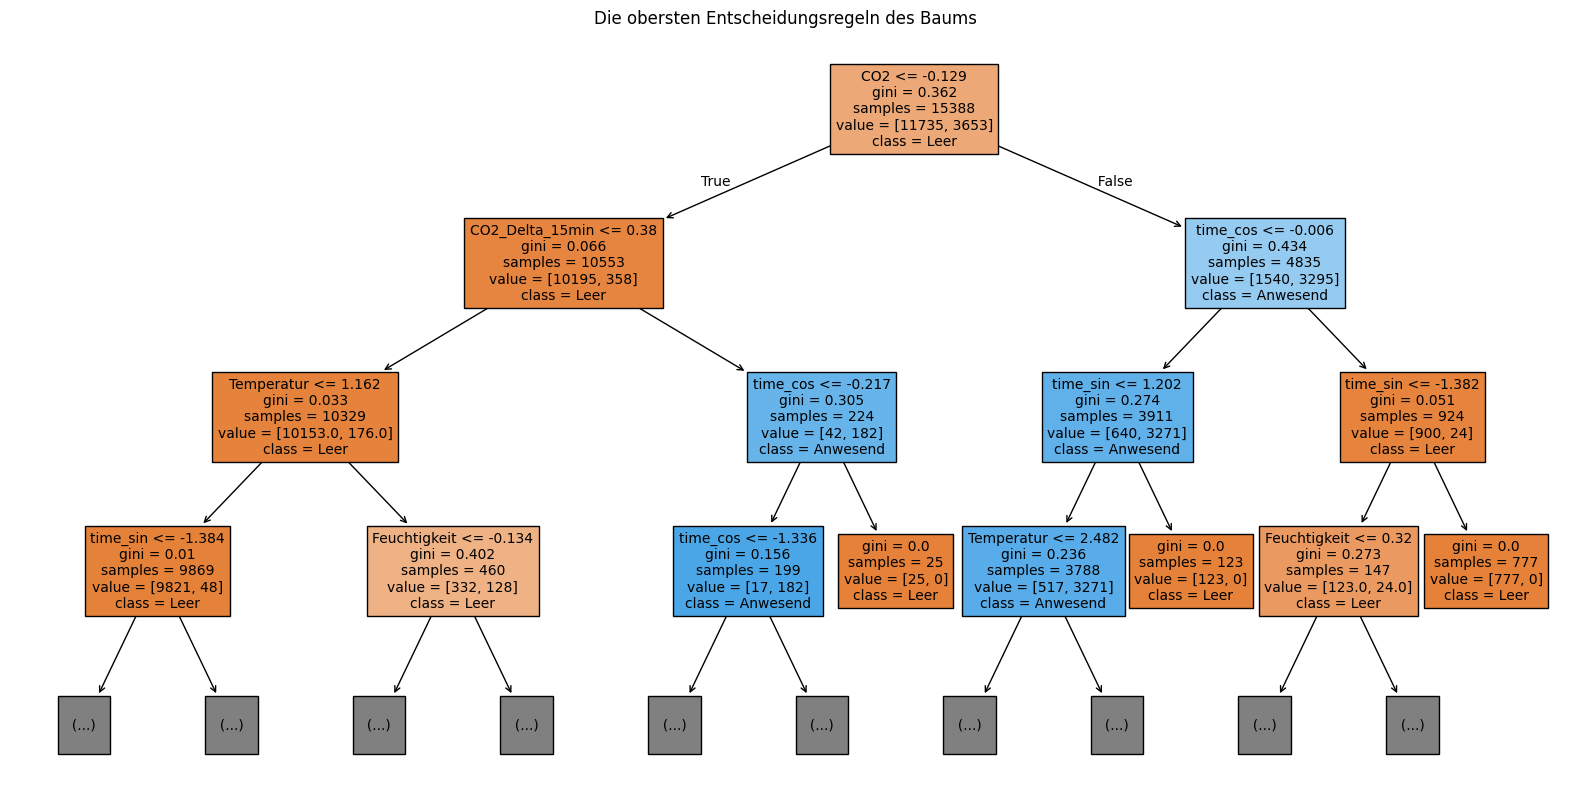

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(
    model_dt, 
    feature_names=X_train_scaled.columns, 
    class_names=["Leer", "Anwesend"],
    filled=True, 
    max_depth=3,
    fontsize=10
)
plt.title("Die obersten Entscheidungsregeln des Baums")
plt.show()

## 4.5 Ergebnisvergleich
Wir fassen die Metriken aller drei Modelle zusammen. Besonderes schauen wir auf den **F1-Score der Klasse 1 (Anwesend)**, da dieser Precision und Recall vereint und uns zeigt, wie gut das Modell Personen erkennt.

In [19]:
# DataFrame erstellen
results_df = pd.DataFrame(results_list)
results_df = results_df.round(4)

# Anzeigen
print("Vergleich der Modelle:")
display(results_df)

Vergleich der Modelle:


Modell  Accuracy  Precision (1)  Recall (1)  F1-Score (1)
0  Logistische Regression    0.8831         0.6107      1.0000        0.7583
1           Random Forest    0.9919         0.9617      0.9958        0.9784
2  Hist Gradient Boosting    0.9899         0.9730      0.9717        0.9724
3       Entscheidungsbaum    0.8373         0.5315      0.9561        0.6832

In [ ]:
metrics_df = results_df.copy()

# Auf Model als Index setzen und Metriken als Matrix verwenden
heat_data = metrics_df.set_index("Modell")

# Plotly Heatmap erstellen (ähnlich wie bei der Feature-Importance)
fig_metrics_heat = px.imshow(
    heat_data,
    text_auto=".3f",
    aspect="auto",
    color_continuous_scale="Blues",
    title="Modellvergleich über Metriken"
)
fig_metrics_heat.update_layout(template="plotly_white", xaxis_title="Metrik", yaxis_title=None)
fig_metrics_heat.show()

# 5. Modell-Optimierung (Hyperparameter Tuning)

## 5.1 Hyperparameter-Optimierung (GridSearch)

Standard-Algorithmen verwenden Voreinstellungen, die selten optimal für das konkrete Problem sind. Um die Leistung des **Random Forest** zu maximieren und Overfitting zu vermeiden, führen wir eine Suche nach den besten Einstellungen durch (**Grid Search**).

Das Vorgehen:

1.  **Suchraum (`param_grid`):** Wir definieren verschiedene Kombinationen von Hyperparametern, die getestet werden sollen:
    * `n_estimators`: Anzahl der Bäume im Wald.
    * `max_depth`: Die maximale Tiefe eines Baumes.
    * `min_samples_split/leaf`: Bestimmt, wie fein die Äste wachsen dürfen.

2.  **Validierung (`cv=tscv`):**
    * Hier kommt erneut unser **TimeSeriesSplit** zum Einsatz.
    * Jede Parameter-Kombination wird mehrfach auf vergangenheitsbasierten Daten trainiert und geprüft. So stellen wir sicher, dass wir nicht zufällig eine Einstellung wählen die nur auf einem Zeitabschnitt gut funktioniert.

3.  **Auswahl:**
    * Das Modell, das im Durchschnitt (Cross-Validation Score) am besten abgeschnitten hat, wird als `best_rf_model` gespeichert.
    * Erst danach erfolgt die **finale Prüfung** auf den Testdaten (`X_test_scaled`), die das Modell während der Optimierung nie gesehen hat.

In [20]:
# Definieren das Gitter (die Kandidaten)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 3, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 6],
}

# GridSearch initialisieren
# cv=tscv nimmt deine Zeitreihen-Strategie von vorhin
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1, # Alle Kerne nutzen
    verbose=1,
    scoring="roc_auc"
)

grid_search.fit(X_train_scaled, y_train)

# Das beste Modell speichern
best_rf_model = grid_search.best_estimator_

print(f"\nBeste Parameter: {grid_search.best_params_}")

# Vorhersage mit dem besten Modell auf den Test-Daten
y_pred_optimiert = best_rf_model.predict(X_test_scaled)

# Vergleich:
print("Ergebnis des optimierten Modells auf Testdaten:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimiert):.4f}")
print(classification_report(y_test, y_pred_optimiert))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Beste Parameter: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
Ergebnis des optimierten Modells auf Testdaten:
Accuracy: 0.9886
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3142
           1       0.94      1.00      0.97       706

    accuracy                           0.99      3848
   macro avg       0.97      0.99      0.98      3848
weighted avg       0.99      0.99      0.99      3848



In [21]:
# Definieren das Gitter (die Kandidaten)
param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_iter': [100, 200, 300],             
    'max_leaf_nodes': [15, 31, 63],          
    'l2_regularization': [0, 0.1, 1.0]       
}

# GridSearch initialisieren
grid_search_gb = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    cv=tscv,               
    scoring='roc_auc',     
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train_scaled, y_train)

# Das beste Modell speichern
best_gb_model = grid_search_gb.best_estimator_

print(f"\nBeste Parameter: {grid_search_gb.best_params_}")
# Testen auf den Testdaten
y_pred_gb_opt = best_gb_model.predict(X_test_scaled)

print("Ergebnis des optimierten GB-Modells auf Testdaten")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_opt):.4f}")
print(classification_report(y_test, y_pred_gb_opt))

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Beste Parameter: {'l2_regularization': 1.0, 'learning_rate': 0.2, 'max_iter': 200, 'max_leaf_nodes': 15}
Ergebnis des optimierten GB-Modells auf Testdaten
Accuracy: 0.9893
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3142
           1       0.97      0.97      0.97       706

    accuracy                           0.99      3848
   macro avg       0.98      0.98      0.98      3848
weighted avg       0.99      0.99      0.99      3848



## 5.2 Analyse der Feature Importance

Ein häufiger Kritikpunkt an komplexen Modellen ist, dass man nicht erkennt was passiert.

* **Ziel:** Transparenz schaffen
* **Plausibilitätsprüfung:** Wir erwarten, dass physikalisch Indikatoren (wie `CO2`) eine höhere Wichtigkeit haben als Zeit-Features.

In [ ]:

# Feature-Namen
feature_names = X_train_scaled.columns.tolist()

# DataFrame mit den Features als Zeilen
df_imp_matrix = pd.DataFrame(index=feature_names)



# Random Forest (hat feature_importances_)
if hasattr(best_rf_model, 'feature_importances_'):
    df_imp_matrix['Random Forest'] = best_rf_model.feature_importances_

# Logistische Regression (hat coef_)
if hasattr(model_lr, 'coef_'):
    # Wir nehmen den Betrag, da -0.5 genauso wichtig ist wie +0.5
    df_imp_matrix['Logistic Reg.'] = abs(model_lr.coef_[0])

# Gradient Boosting (Hist) - braucht Permutation Importance
# Da HistGradientBoosting keine .feature_importances_ hat, berechnen wir sie
try:
    perm_result = permutation_importance(
        best_gb_model, X_test_scaled, y_test, 
        n_repeats=5, random_state=42, n_jobs=-1
    )
    df_imp_matrix['Gradient Boosting'] = perm_result.importances_mean
except Exception as e:
    print(f"Fehler: {e}")

# Normalisierung
df_imp_normalized = df_imp_matrix.apply(lambda x: x / x.sum())

# Anzeigen
print("Feature Importance Matrix (Nicht Normalisiert)")
display(df_imp_matrix.round(4))

# Plot (Heatmap)
fig_heat = px.imshow(
    df_imp_normalized.T,
    text_auto='.2f',
    aspect="auto",
    color_continuous_scale="Blues",
    title="Wer achtet worauf? (Feature Importance Vergleich / Normalisiert)",
    
)
fig_heat.update_layout(template="plotly_white")
fig_heat.show()

Feature Importance Matrix (Nicht Normalisiert)


Random Forest  Logistic Reg.  Gradient Boosting
Temperatur               0.1737         0.2167             0.0040
Feuchtigkeit             0.0150         0.0044            -0.0004
CO2                      0.2537         0.2549             0.0075
Wassergehalt             0.0179         0.0799             0.0017
Wochentag                0.0230         0.0614             0.0005
time_sin                 0.0354         0.0531             0.0955
time_cos                 0.1780         0.2477             0.1087
CO2_Delta_15min          0.1252         0.0932            -0.0017
Tagesart_Werktag         0.0069         0.1327             0.0000
Ist_Buerozeit            0.1712         0.2928             0.1675

## 5.3 Fehleranalyse (Confusion Matrix)
Abschließend prüfen wir mit der Confusion Matrix, wo genau das optimierte Modell noch Fehler machen.

In [23]:


# Vorhersagen machen
y_pred_opt = best_rf_model.predict(X_test_scaled)
y_pred_gb = best_gb_model.predict(X_test_scaled)      
y_pred_lg = model_lr.predict(X_test_scaled)    

# Matrizen berechnen
cm_rf = confusion_matrix(y_test, y_pred_opt)
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_lg = confusion_matrix(y_test, y_pred_lg)

# Plotten (Random Forest)
fig_cm = px.imshow(cm_rf,
                   text_auto=True,
                   x=["Leer (0)", "Besetzt (1)"],
                   y=["Leer (0)", "Besetzt (1)"],
                   color_continuous_scale="Blues",
                   title="Confusion Matrix (Optimierter Random Forest)")
fig_cm.update_layout(xaxis_title="Vorhersage", yaxis_title="Wahrheit")
fig_cm.show()

# Plotten (Gradient Boosting)
fig_cm2 = px.imshow(cm_gb,
                    text_auto=True,
                    x=["Leer (0)", "Besetzt (1)"],
                    y=["Leer (0)", "Besetzt (1)"],
                    color_continuous_scale="Blues",
                    title="Confusion Matrix (Optimierte Gradient Boosting)")
fig_cm2.update_layout(xaxis_title="Vorhersage", yaxis_title="Wahrheit")
fig_cm2.show()

# Plotten (Logistische Regression)
fig_cm3 = px.imshow(cm_lg,
                    text_auto=True,
                    x=["Leer (0)", "Besetzt (1)"],
                    y=["Leer (0)", "Besetzt (1)"],
                    color_continuous_scale="Blues",
                    title="Confusion Matrix (Logistische Regression)")
fig_cm3.update_layout(xaxis_title="Vorhersage", yaxis_title="Wahrheit")
fig_cm3.show()

## 5.4 Modellvergleich mittels ROC-Analyse

Um den endgültigen Gewinner unter den Algorithmen zu ermitteln, reicht die reine Genauigkeit (Accuracy) oft nicht aus. Stattdessen nutzen wir die **Receiver Operating Characteristic (ROC)**.

Dabei betrachten wir nicht nur die Klassifizierung (0 oder 1), sondern die **Wahrscheinlichkeit** (`predict_proba`), mit der das Modell eine Anwesenheit vermutet.

* **X-Achse (False Positive Rate):** Wie oft schlägt das Modell falschen Alarm, obwohl niemand da ist?
* **Y-Achse (True Positive Rate):** Wie viele der tatsächlichen Anwesenheiten werden erkannt?


**Die Metrik AUC (Area Under the Curve):**
Der Flächeninhalt unter der Kurve fasst die Qualität in einer Zahl zusammen:
* **AUC = 0.5:** Das Modell rät nur (Zufall, graue Linie).
* **AUC = 1.0:** Perfekte Trennung von Anwesenheit und Abwesenheit.

Das Modell, dessen Kurve am weitesten oben links verläuft (und den höchsten AUC-Wert hat), ist das robusteste Modell für unseren Anwendungsfall.

In [25]:

# Wahrscheinlichkeiten holen
y_probs_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]
y_probs_gb = best_gb_model.predict_proba(X_test_scaled)[:, 1]
y_probs_lg = model_lr.predict_proba(X_test_scaled)[:, 1]

# ROC Daten berechnen
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_probs_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
# Logistische Regression
fpr_lg, tpr_lg, _ = roc_curve(y_test, y_probs_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

# Plotten
fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, name=f"Random Forest (AUC = {roc_auc_rf:.3f})"))
fig_roc.add_trace(go.Scatter(x=fpr_gb, y=tpr_gb, name=f"Gradient Boosting (AUC = {roc_auc_gb:.3f})"))
fig_roc.add_trace(go.Scatter(x=fpr_lg, y=tpr_lg, name=f"Logistische Regression (AUC = {roc_auc_lg:.3f})"))

# Diagonale (Zufallslinie)
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash", color="grey"), name="Zufall (Raten)"))

fig_roc.update_layout(
    title="ROC Kurve Vergleich: Welches Modell ist am besten?",
    xaxis_title="False Positive Rate", 
    yaxis_title="True Positive Rate (Recall)",
    template="plotly_white",
)
fig_roc.show()

# 6. Wirtschaftliche Bewertung und Optimierung

In der Praxis ist nicht immer das Modell mit der höchsten Accuracy das beste. Hier gelten folgende Regeln:
1.  **Komfort:** Falsch-Negative Vorhersagen (Person da, Heizung aus) sind kritisch. Durchschnittlich darf dies max. 60 Min/Tag passieren.
2.  **Kosten:** Unter den Modellen, gewinnt das günstigste (geringste Laufzeit).

### Wie können wir die Modelle verbessern? (Threshold Tuning)
Aktuell entscheiden die Modelle bei einer Wahrscheinlichkeit von > 50%, dass jemand anwesend ist.
Um die **Mitarbeiterzufriedenheit** (Komfort) zu steigern, müssen wir diesen **Schwellenwert (Threshold) senken** (z. B. auf 20%).
* **Konsequenz:** Das Modell schaltet die Heizung schon bei geringstem Verdacht an.
* **Vorteil:** False Negatives (Frieren) sinken drastisch -> Komfort steigt.
* **Nachteil:** False Positives (Heizen leerer Räume) steigen -> Kosten steigen.

### Auf welche Metriken achten wir?
Da "Zufriedenheit an erster Stelle" steht, ist **Recall (Sensitivität)** die wichtigste Metrik.
* Ein **Recall von 1.0** bedeutet: Nie frieren (Perfekter Komfort).
* Die **Precision** ist zweitrangig, korreliert aber direkt mit den Kosten (niedrige Precision = hohe Kosten durch unnötiges Heizen).

In [26]:
# Parameter definieren
kosten_pro_stunde = 5.0  # Euro
max_frieren_pro_tag_minuten = 60 # Minuten

# Wir ermitteln, wie viele Tage der Test-Datensatz umfasst
# Ein Tag hat 1440 Minuten (Datenpunkte)
anzahl_tage_test = len(y_test) / 1440
print(f"Betrachteter Zeitraum im Test-Set: {anzahl_tage_test:.1f} Tage")

results_econ = []

# Liste trainierten Modelle
modelle_dict = {
    # "Decision Tree": model_dt, <---- Optional
    "Logistische Reg.": model_lr,
    "Random Forest": best_rf_model,
    "Gradient Boosting": best_gb_model
}

print(f"\nAuswertung")

for name, model in modelle_dict.items():
    # Vorhersage auf Testdaten
    y_pred = model.predict(X_test_scaled)
    
    # Confusion Matrix
    # TN = True Negative (Heizung aus, niemand da) -> Gut
    # FP = False Positive (Heizung an, niemand da) -> Kosten
    # FN = False Negative (Heizung aus, jemand da) -> kalt
    # TP = True Positive (Heizung an, jemand da)   -> Kosten, aber nötig
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Prüfen der Zufriedenheit
    minuten_frieren_total = fn # Da 1 Zeile = 1 Minute
    minuten_frieren_pro_tag = minuten_frieren_total / anzahl_tage_test
    
    is_acceptable = minuten_frieren_pro_tag <= max_frieren_pro_tag_minuten
    
    # Kosten berechnen
    # Die Heizung läuft immer, wenn das Modell 1 sagt (TP + FP)
    minuten_laufzeit = tp + fp
    stunden_laufzeit = minuten_laufzeit / 60
    gesamtkosten = stunden_laufzeit * kosten_pro_stunde
    
    results_econ.append({
        "Modell": name,
        "Frieren (Min/Tag)": round(minuten_frieren_pro_tag, 1),
        "Akzeptabel?": "JA" if is_acceptable else "NEIN (Disqualifiziert)",
        "Gesamtkosten (€)": round(gesamtkosten, 2),
        "Laufzeit (Std)": round(stunden_laufzeit, 1)
    })

# Tabelle anzeigen
df_econ = pd.DataFrame(results_econ)
df_econ = df_econ.sort_values("Gesamtkosten (€)")
display(df_econ)

# Gewinner
df_valid = df_econ[df_econ["Akzeptabel?"] == "JA"].sort_values("Gesamtkosten (€)")

if not df_valid.empty:
    sieger = df_valid.iloc[0]
    print(f"\nDER GEWINNER IST: {sieger['Modell']}")
    print(f"Begründung: Es hält die Komfort-Grenze ein ({sieger['Frieren (Min/Tag)']} Min Frieren/Tag) und verursacht die geringsten Kosten ({sieger['Gesamtkosten (€)']} €).")
else:
    print("\nKein Gewinner: Alle Modelle verletzen die Komfort-Grenze!")

Betrachteter Zeitraum im Test-Set: 2.7 Tage

Auswertung


Modell  Frieren (Min/Tag) Akzeptabel?  Gesamtkosten (€)  \
2  Gradient Boosting                8.2          JA             58.58   
1      Random Forest                0.0          JA             62.50   
0   Logistische Reg.                0.0          JA             96.33   

   Laufzeit (Std)  
2            11.7  
1            12.5  
0            19.3


DER GEWINNER IST: Gradient Boosting
Begründung: Es hält die Komfort-Grenze ein (8.2 Min Frieren/Tag) und verursacht die geringsten Kosten (58.58 €).


In [37]:
best_threshold_model = None
best_cost = float('inf')
best_params = {}

# Wir testen das am besten geeignete Modell (z.B. Random Forest oder Boosting)
# Random Forest
model_to_tune = best_rf_model 

# Gradient Boosting
# model_to_tune = best_gb_model

y_probs = model_to_tune.predict_proba(X_test_scaled)[:, 1]

# Wir testen Schwellenwerte von 0.5 bis 1 in 0.05/0.01 Schritten
thresholds = np.arange(0.5, 1, 0.01)
tuning_results = []

for thresh in thresholds:
    # Neue Vorhersage basierend auf der Schwelle
    # Wenn Wahrscheinlichkeit > thresh, dann 1 (Anwesend), sonst 0
    y_pred_new = (y_probs >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_new).ravel()
    
    # Metriken berechnen
    frieren_pro_tag = fn / anzahl_tage_test
    laufzeit_std = (tp + fp) / 60
    kosten = laufzeit_std * kosten_pro_stunde
    
    acceptable = frieren_pro_tag <= max_frieren_pro_tag_minuten
    
    tuning_results.append({
        "Threshold": f"{thresh:.2f}",
        "Frieren (Min/Tag)": round(frieren_pro_tag, 1),
        "Akzeptabel": acceptable,
        "Kosten (€)": round(kosten, 2)
    })
    
    # Neuer Sieger
    if acceptable and kosten < best_cost:
        best_cost = kosten
        best_threshold_model = {
            "Threshold": thresh,
            "Kosten": kosten,
            "Frieren": frieren_pro_tag
        }

# Tabelle anzeigen
df_tuning = pd.DataFrame(tuning_results)
display(df_tuning)

if best_threshold_model:
    print(f"Setze den Threshold auf {best_threshold_model['Threshold']:.2f}.")
    print(f"Frieren: {best_threshold_model['Frieren']:.1f} Min/Tag (Erlaubt: 60)")
    print(f"Kosten:  {best_threshold_model['Kosten']:.2f} €")
else:
    print("Selbst mit Tuning konnte die Bedingung nicht erfüllt werden.")

Threshold  Frieren (Min/Tag)  Akzeptabel  Kosten (€)
0       0.50                0.0        True       62.50
1       0.51                0.0        True       62.50
2       0.52                0.0        True       62.42
3       0.53                0.0        True       61.92
4       0.54                0.0        True       61.58
5       0.55                0.0        True       61.42
6       0.56                0.0        True       61.08
7       0.57                0.0        True       60.83
8       0.58                0.0        True       60.67
9       0.59                0.0        True       60.58
10      0.60                0.4        True       60.42
11      0.61                0.4        True       60.42
12      0.62                0.4        True       60.33
13      0.63                0.4        True       60.25
14      0.64                0.7        True       60.17
15      0.65                1.1        True       60.00
16      0.66                1.1        True       60.00
17      0.67                1.1        True       59.83
18      0.68                1.1        True       59.83
19      0.69                1.5        True       59.67
20      0.70                2.6        True       59.42
21      0.71                2.6        True       59.42
22      0.72                3.0        True       59.33
23      0.73                3.4        True       59.17
24      0.74                4.1        True       59.00
25      0.75                5.6        True       58.67
26      0.76                9.0        True       57.92
27      0.77               13.1        True       57.00
28      0.78               22.5        True       54.83
29      0.79               39.3        True       50.92
30      0.80               58.0        True       46.58
31      0.81               69.6       False       43.83
32      0.82               76.7       False       42.17
33      0.83               86.1       False       40.08
34      0.84               96.5       False       37.75
35      0.85              100.7       False       36.50
36      0.86              105.5       False       35.42
37      0.87              117.9       False       32.67
38      0.88              128.7       False       30.17
39      0.89              135.5       False       28.67
40      0.90              145.6       False       26.42
41      0.91              154.9       False       24.33
42      0.92              167.7       False       21.50
43      0.93              183.0       False       18.08
44      0.94              219.3       False       10.00
45      0.95              245.9       False        4.08
46      0.96              264.2       False        0.00
47      0.97              264.2       False        0.00
48      0.98              264.2       False        0.00
49      0.99              264.2       False        0.00

Setze den Threshold auf 0.80.
Frieren: 58.0 Min/Tag (Erlaubt: 60)
Kosten:  46.58 €


In [28]:
# Wir definieren die beiden Kandidaten
modelle_check = {
    "1. Random Forest (best_rf_model)": best_rf_model,
    "2. Gradient Boosting (best_gb_model)": best_gb_model
}

print(f"Anzahl Testdaten: {len(y_test)}")
print(f"Echte Verteilung: {y_test.value_counts().to_dict()} (0=Leer, 1=Besetzt)")


for name, model in modelle_check.items():
    print("-" * 40)
    print(f"Modell: {name}")
    
    # Wahrscheinlichkeiten holen
    probs = model.predict_proba(X_test_scaled)[:, 1]
    
    # Statistik der Wahrscheinlichkeiten
    p_min = probs.min()
    p_max = probs.max()
    p_mean = probs.mean()
    
    print(f"Wie sicher ist sich das Modell maximal? {p_max:.4f} (Max)")
    print(f"Wie unsicher ist es mindestens?       {p_min:.4f} (Min)")
    print(f"Durchschnittliche Wahrscheinlichkeit: {p_mean:.4f}")
    
    # Wo ist das Modell sicherer als 90%?
    mask_hohe_sicherheit = probs > 0.90
    
    # Summe
    anzahl_hoch = np.sum(mask_hohe_sicherheit)
    
    # Wie viele davon sind in Wirklichkeit "Besetzt" (1)?
    echte_treffer = np.sum(y_test.values[mask_hohe_sicherheit] == 1)
    
    print(f"Anzahl Fälle mit > 90% Sicherheit:    {anzahl_hoch}")
    
    # Schutz vor Division durch Null
    if anzahl_hoch > 0:
        quote = echte_treffer / anzahl_hoch * 100
        print(f"Davon tatsächlich 'Besetzt' (1):  {echte_treffer} ({quote:.1f}%)")
    else:
        print("Keine Fälle mit so hoher Sicherheit gefunden.")
        

Anzahl Testdaten: 3848
Echte Verteilung: {0: 3142, 1: 706} (0=Leer, 1=Besetzt)
----------------------------------------
Modell: 1. Random Forest (best_rf_model)
Wie sicher ist sich das Modell maximal? 0.9551 (Max)
Wie unsicher ist es mindestens?       0.0001 (Min)
Durchschnittliche Wahrscheinlichkeit: 0.2563
Anzahl Fälle mit > 90% Sicherheit:    317
Davon tatsächlich 'Besetzt' (1):  317 (100.0%)
----------------------------------------
Modell: 2. Gradient Boosting (best_gb_model)
Wie sicher ist sich das Modell maximal? 0.9999 (Max)
Wie unsicher ist es mindestens?       0.0000 (Min)
Durchschnittliche Wahrscheinlichkeit: 0.1829
Anzahl Fälle mit > 90% Sicherheit:    628
Davon tatsächlich 'Besetzt' (1):  619 (98.6%)


# 7. Anwendungs-Test (Simulation / Deployment)

Zum Abschluss simulieren wir den Einsatz des Modells in der Realität. Wir laden einen neuen Datensatz (z. B. vom Dozenten bereitgestellt oder eine Simulation), den die Modelle während des Trainings **nie gesehen** haben.

Wichtige Aspekte:

1.  **Pipeline-Konsistenz:** Die neuen Daten durchlaufen exakt dieselben Vorverarbeitungsschritte (Runden, Feature Engineering) wie die Trainingsdaten.
2.  **Vermeidung von Data Leakage:**
    * Die Zielvariable (`Anwesenheit`) wird sofort abgetrennt und nur für die finale Erfolgskontrolle gespeichert. Die Modelle erhalten diese Information nicht.
    * **Skalierung:** Wir nutzen den `StandardScaler`, der auf den *Trainingsdaten* gefittet wurde (`transform`). Wir berechnen *keine* neuen Mittelwerte auf den Testdaten, um die statistische Vergleichbarkeit zu halten.
3.  **Vergleich:** Alle trainierten Modelle geben ihre Prognose für die neuen Daten ab. So können wir prüfen, welches Modell auf völlig unbekannten Daten am besten reagiert.

In [29]:
# Wir laden das Original nochmal
df_raw = pd.read_csv("Data/Datensatz-Sensor.csv")

# Wir nehmen 20 zufällige Zeilen als "Stichprobe"
df_simulation = df_raw.sample(20, random_state=46)

# Wir speichern das als neue Datei ab
df_simulation.to_csv("testdaten_simulation.csv", index=False)

print("Simulations-Datei erstellt: 'testdaten_simulation.csv'")

Simulations-Datei erstellt: 'testdaten_simulation.csv'


In [30]:
# Dateinamen anpassen (Simulation oder echt)
dateiname = "testdaten_simulation.csv" # <-----------

try:
    print(f"Lade Datei: {dateiname}")
    df_doz_test = pd.read_csv(dateiname)


    # Daten säubern (Exakt wie im Training)
    # Datum korrigieren
    if df_doz_test["Datum"].dtype == "object":
        df_doz_test["Datum"] = pd.to_datetime(df_doz_test["Datum"])
    
    mask_59 = df_doz_test["Datum"].dt.second == 59
    if mask_59.sum() > 0:
        df_doz_test.loc[mask_59, "Datum"] += pd.Timedelta(seconds=1)

    # Ausreißer & Lücken
    df_doz_test.loc[df_doz_test["Temperatur"] > 40, "Temperatur"] = np.nan
    df_doz_test.loc[df_doz_test["CO2"] < 50, "CO2"] = np.nan
    df_doz_test = df_doz_test.interpolate(method="linear", limit_direction="both")

    # Features erstellen
    df_doz_test_final = erstelle_features(df_doz_test)

    # Lösung trennen (falls vorhanden)
    y_doz_echt = None
    if "Anwesenheit" in df_doz_test_final.columns:
        y_doz_echt = df_doz_test_final["Anwesenheit"]
        X_doz = df_doz_test_final.drop(columns=["Anwesenheit"])
    else:
        X_doz = df_doz_test_final.copy()

    # Unnötige Spalten weg
    cols_to_drop = ["Datum", "Jahr"]
    X_doz = X_doz.drop(columns=[c for c in cols_to_drop if c in X_doz.columns])

    # Skalieren (Mit Scaler vom Training!)
    X_doz_scaled = pd.DataFrame(scaler.transform(X_doz), columns=X_doz.columns)
    
    print("Daten erfolgreich vorbereitet.\n")

    # Wir packen alle Modelle in eine Liste (Dictionary)
    meine_modelle = {
        # "Decision Tree": model_dt, <-- Falls gewünscht (Optional)
        "Logistische Reg.": model_lr,
        "Random Forest": best_rf_model,
        "Gradient Boosting": best_gb_model
    }
    
    # Wir speichern die Ergebnisse in einer Tabelle
    df_ergebnisse = df_doz_test[["Datum"]].copy()
    
    # Wenn wir die echte Lösung haben, speichern wir sie auch
    if y_doz_echt is not None:
        df_ergebnisse["ECHT"] = y_doz_echt

    print("Start der Vorhersagen")
    
    for modell_name, modell_objekt in meine_modelle.items():
        # Vorhersage machen
        pred = modell_objekt.predict(X_doz_scaled)
        
        # In Tabelle speichern
        df_ergebnisse[modell_name] = pred
        
        # Falls Lösung vorhanden: Direkt Genauigkeit berechnen
        if y_doz_echt is not None:
            acc = accuracy_score(y_doz_echt, pred)
            print(f"Genauigkeit {modell_name}: {acc:.2%}")

    print("\nAuszug aus den Vorhersagen")
    display(df_ergebnisse.head(10))
    
    # Als CSV speichern
    df_ergebnisse.to_csv("meine_vorhersagen.csv", index=False)
    print("\nAlle Vorhersagen wurden in 'meine_vorhersagen.csv' gespeichert.")

except FileNotFoundError:
    print(f"Fehler: Datei '{dateiname}' nicht gefunden.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")

Lade Datei: testdaten_simulation.csv
Daten erfolgreich vorbereitet.

Start der Vorhersagen
Genauigkeit Logistische Reg.: 80.00%
Genauigkeit Random Forest: 90.00%
Genauigkeit Gradient Boosting: 100.00%

Auszug aus den Vorhersagen


Datum  ECHT  Logistische Reg.  Random Forest  \
0 2015-02-12 07:34:00     0                 1              0   
1 2015-02-14 03:43:00     0                 0              0   
2 2015-02-17 02:20:00     0                 0              0   
3 2015-02-13 13:15:00     0                 1              1   
4 2015-02-04 21:33:00     0                 0              0   
5 2015-02-09 13:54:00     1                 1              1   
6 2015-02-03 16:47:00     1                 1              1   
7 2015-02-13 16:58:00     1                 1              1   
8 2015-02-03 22:27:00     0                 0              0   
9 2015-02-08 23:01:00     0                 0              0   

   Gradient Boosting  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
5                  1  
6                  1  
7                  1  
8                  0  
9                  0


Alle Vorhersagen wurden in 'meine_vorhersagen.csv' gespeichert.
